# **QuoteSense: A Multi-Model Pipeline for Emotion Detection in Motivational Quotes**

## Importing Libraries

In [2]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and Preprocessing Dataset

In [4]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/quotes_with_semantic_scores.csv")
df.head()

,Quote,Emotion,Author,CreativityScore,PoeticToneScore,EmotionalBalanceIndex,SemanticClicheScore
0,"Speak your fear, and it loses its grip.",Fear,AI Generated,1.000000,0.000000,0.700,0.5987
1,Patience is the companion of wisdom.,Wisdom,AI Generated,1.000000,0.399760,1.000,0.3936
2,But the deep desire for peace remained with th...,Gratitude,Paul Robeson,0.858915,0.218487,1.000,0.2317
3,"Real love is not found, it's built daily.",Love,AI Generated,1.000000,0.000000,0.625,0.4638
4,A grateful heart is a magnet for miracles.,Gratitude,AI Generated,0.806202,0.300120,1.000,0.4332


In [6]:
df = df.drop_duplicates(subset="Quote").reset_index(drop=True)

## Encoding and Splitting Data

In [7]:
X = df["Quote"].astype(str)
y = df["Emotion"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## TF-IDF and Logistic Regression ML Model

In [9]:
#Vectorizing text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Training classifier
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)

#Predicting and evaluating the model
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       Anger       1.00      0.59      0.74        51
        Fear       0.88      0.64      0.74       142
   Gratitude       0.86      0.60      0.70        52
         Joy       0.87      0.71      0.78       102
  Leadership       0.94      0.57      0.71       148
        Love       0.78      0.40      0.53        52
     Sadness       0.00      0.00      0.00         7
    Surprise       0.00      0.00      0.00        10
      Wisdom       0.81      0.98      0.89       974

    accuracy                           0.83      1538
   macro avg       0.68      0.50      0.57      1538
weighted avg       0.83      0.83      0.82      1538



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## LSTM Model

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=30)
X_test_pad = pad_sequences(X_test_seq, maxlen=30)

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=30),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=5, validation_split=0.1, batch_size=32)

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6092 - loss: 1.5928 - val_accuracy: 0.6195 - val_loss: 1.3120
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6539 - loss: 1.1369 - val_accuracy: 0.7870 - val_loss: 0.7285
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8601 - loss: 0.4801 - val_accuracy: 0.8634 - val_loss: 0.5507
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9338 - loss: 0.2430 - val_accuracy: 0.8634 - val_loss: 0.5621
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9561 - loss: 0.1657 - val_accuracy: 0.8683 - val_loss: 0.5542
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.6766
Test Accuracy: 0.8492


In [11]:
!pip install transformers datasets evaluate scikit-learn

## DistilBERT Model

In [12]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

#convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=64)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/6150 [00:00<?, ? examples/s]

Map:   0%|          | 0/1538 [00:00<?, ? examples/s]

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
!pip install numpy==1.26.4

In [15]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=9
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#Training the model
import evaluate
from transformers import Trainer, TrainingArguments

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()


/tmp/ipython-input-16-964273932.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.628400
1000,0.222900


TrainOutput(global_step=1155, training_loss=0.39129466102236793, metrics={'train_runtime': 41.8123, 'train_samples_per_second': 441.258, 'train_steps_per_second': 27.623, 'total_flos': 305541075628800.0, 'train_loss': 0.39129466102236793, 'epoch': 3.0})

In [17]:
import numpy as np

from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

from sklearn.preprocessing import LabelEncoder
print(classification_report(y_true, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        51
        Fear       0.88      0.92      0.90       142
   Gratitude       0.81      0.92      0.86        52
         Joy       0.83      0.94      0.88       102
  Leadership       0.90      0.86      0.88       148
        Love       0.77      0.85      0.81        52
     Sadness       1.00      0.29      0.44         7
    Surprise       0.50      0.30      0.38        10
      Wisdom       0.95      0.94      0.94       974

    accuracy                           0.92      1538
   macro avg       0.85      0.78      0.79      1538
weighted avg       0.92      0.92      0.92      1538



# Visualisations and Findings

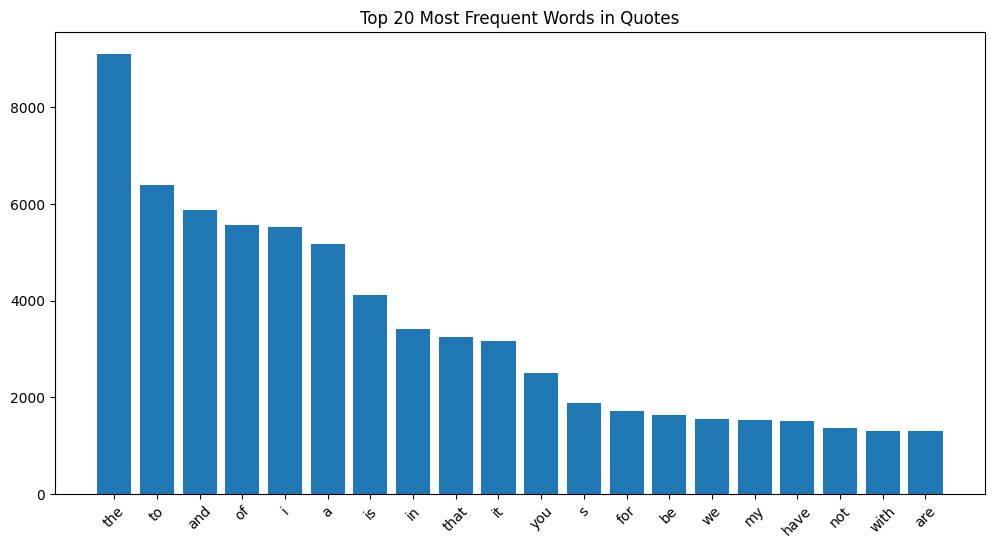

In [18]:
import matplotlib.pyplot as plt
from collections import Counter
import re

all_words = []
for quote in df['Quote']:
    words = re.findall(r'\b\w+\b', quote.lower())
    all_words.extend(words)

word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

words, counts = zip(*most_common)
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Quotes")
plt.show()


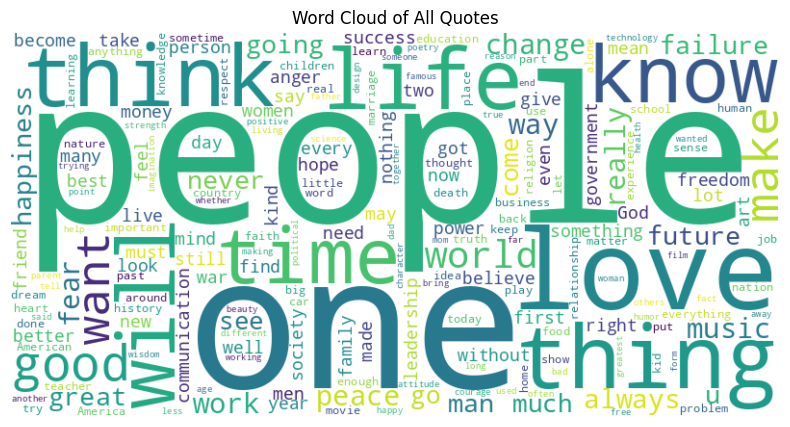

In [19]:
from wordcloud import WordCloud

text = " ".join(df['Quote'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of All Quotes")
plt.show()

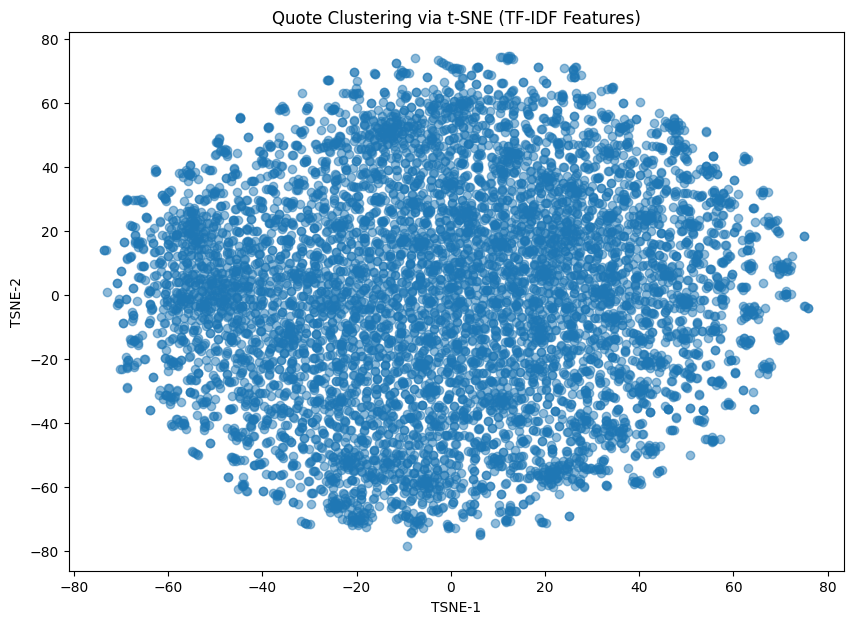

In [20]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_vectors = vectorizer.fit_transform(df["Quote"])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_vectors.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.5)
plt.title("Quote Clustering via t-SNE (TF-IDF Features)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


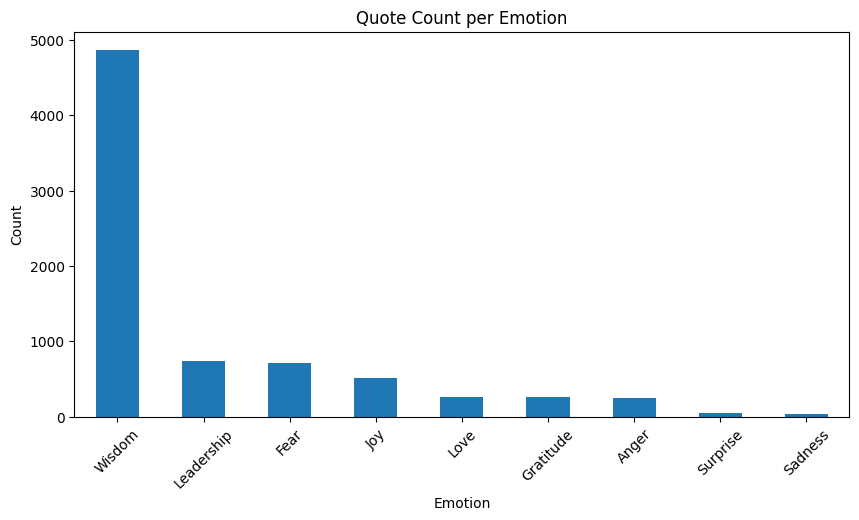

In [21]:
df["Emotion"].value_counts().plot(kind="bar", figsize=(10, 5))
plt.title("Quote Count per Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Predict Emotion for New Quotes

In [24]:
import torch

def predict_emotions_batch(quotes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Tokenize and move to device
    inputs = tokenizer(quotes, return_tensors="pt", truncation=True, padding=True, max_length=64, padding_side="right")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    return [le.classes_[p] for p in preds]

In [25]:
test_quotes = [
    "Let your light shine through every shadow you meet.",
    "Fear is a reaction. Courage is a decision.",
    "Gratitude makes sense of our past, brings peace for today, and creates a vision for tomorrow."
]

predict_emotions_batch(test_quotes)

['Wisdom', 'Fear', 'Gratitude']

# Misclassification Analysis

In [26]:
misclassified = []

for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        quote = X_test.iloc[i]
        true_label = le.classes_[y_true[i]]
        pred_label = le.classes_[y_pred[i]]
        misclassified.append((quote, true_label, pred_label))

#Show a few misclassifications
print(f"Total misclassified: {len(misclassified)}\n")

for i in range(5):  # Show first 5
    quote, actual, predicted = misclassified[i]
    print(f"Quote: {quote}\nActual: {actual}\nPredicted: {predicted}\n---")

Total misclassified: 125

Quote: Young players need freedom of expression to develop as creative players... they should be encouraged to try skills without fear of failure.
Actual: Wisdom
Predicted: Fear
---
Quote: You can't be afraid to put out a fire if you're a fireman. You can't be afraid to be a police officer and carry a gun if you're afraid to get up and go out there. So you've got to put that fear to the side and go out in faith to overcome that.
Actual: Wisdom
Predicted: Fear
---
Quote: Whoever said money can't buy happiness simply didn't know where to go shopping.
Actual: Wisdom
Predicted: Joy
---
Quote: We are increasingly likely to find ourselves in places with background music. No composers have thought to write for these modern spaces, which represent 30% of our musical experience.
Actual: Wisdom
Predicted: Joy
---
Quote: My fellow Americans, ask not what your country can do for you, ask what you can do for your country.
Actual: Sadness
Predicted: Wisdom
---


In [27]:
#only misclassified quotes and labels
mis_quotes = [X_test.iloc[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]]
mis_true = [y_true[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]]
mis_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]]

In [28]:
from sentence_transformers import SentenceTransformer

#loading SBERT model (only once)
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

#embeddings for misclassified quotes
mis_embeddings = sbert_model.encode(mis_quotes, show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

# UMAP Visualization of Misclassifications

In [29]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
mis_2d = reducer.fit_transform(mis_embeddings)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


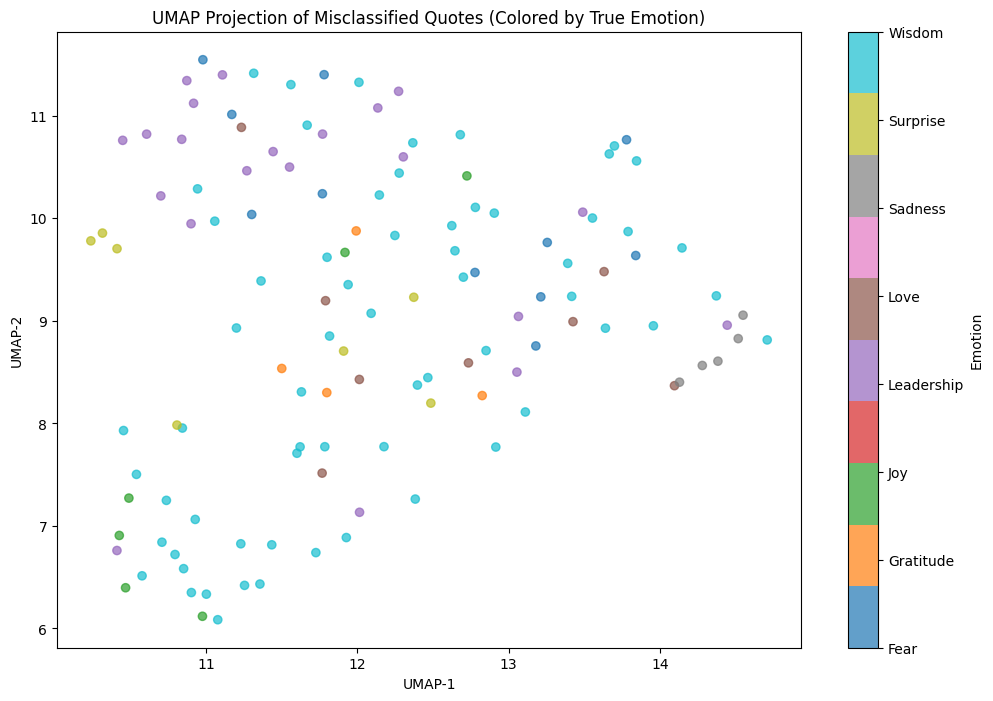

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    mis_2d[:, 0], mis_2d[:, 1],
    c=mis_true,
    cmap="tab10",
    alpha=0.7
)
plt.title("UMAP Projection of Misclassified Quotes (Colored by True Emotion)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Emotion",
             format=plt.FuncFormatter(lambda i, _: le.classes_[int(i)]))
plt.show()